Processing Alpine...
Processing Ararat...
Processing Ballarat...
Processing Banyule...
Processing Bass Coast...
Processing Baw Baw...
Processing Benalla...
Processing Boroondara...
Processing Brimbank...
Processing Campaspe...
Processing Cardinia...
Processing Casey...
Processing Central Goldfields...
Processing Colac-Otway...
Processing Corangamite...
Processing Darebin...
Processing East Gippsland...
Processing Frankston...
Processing Gannawarra...
Processing Glen Eira...
Processing Glenelg...
Processing Golden Plains...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing Greater Bendigo...
Processing Greater Dandenong...
Processing Greater Geelong...
Processing Greater Shepparton...
Processing Hepburn...
Processing Hindmarsh...
Processing Hobsons Bay...
Processing Horsham...
Processing Hume...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing Indigo...
Processing Knox...
Processing Macedon Ranges...
Processing Manningham...
Processing Mansfield...
Processing Maribyrnong...
Processing Maroondah...
Processing Melbourne...
Processing Melton...
Processing Mildura...
Processing Mitchell...
Processing Moira...
Processing Monash...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Moonee Valley...
Processing Moorabool...
Processing Mount Alexander...
Processing Moyne...
Processing Murrindindi...
Processing Nillumbik...
Processing Northern Grampians...
Processing Port Phillip...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing South Gippsland...
Processing Southern Grampians...
Processing Stonnington...
Processing Surf Coast...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Swan Hill...
Processing Towong...
Processing Wangaratta...
Processing Wellington...
Processing Whitehorse...
Processing Whittlesea...
Processing Wodonga...
Processing Wyndham...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Yarra...
Processing Yarra Ranges...
The regions with the highest projected growth over the next three years:
Wyndham       36.821029
Whittlesea    36.120099
Moira         33.711697
Hume          29.329922
Casey         26.548160
Glen Eira     25.939525
Swan Hill     25.339529
Melbourne     24.245395
Monash        22.889746
Whitehorse    22.690086
dtype: float64
Price increase forecast saved to ../data/results/price_increase_forecast_SARIMA.csv


/var/folders/8_/gylgnm051zv9rk4m5lzq6c880000gn/T/ipykernel_39248/2852175773.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(top_regions))


Plot saved at ../plots/price_forecast_top10_SARIMA.png


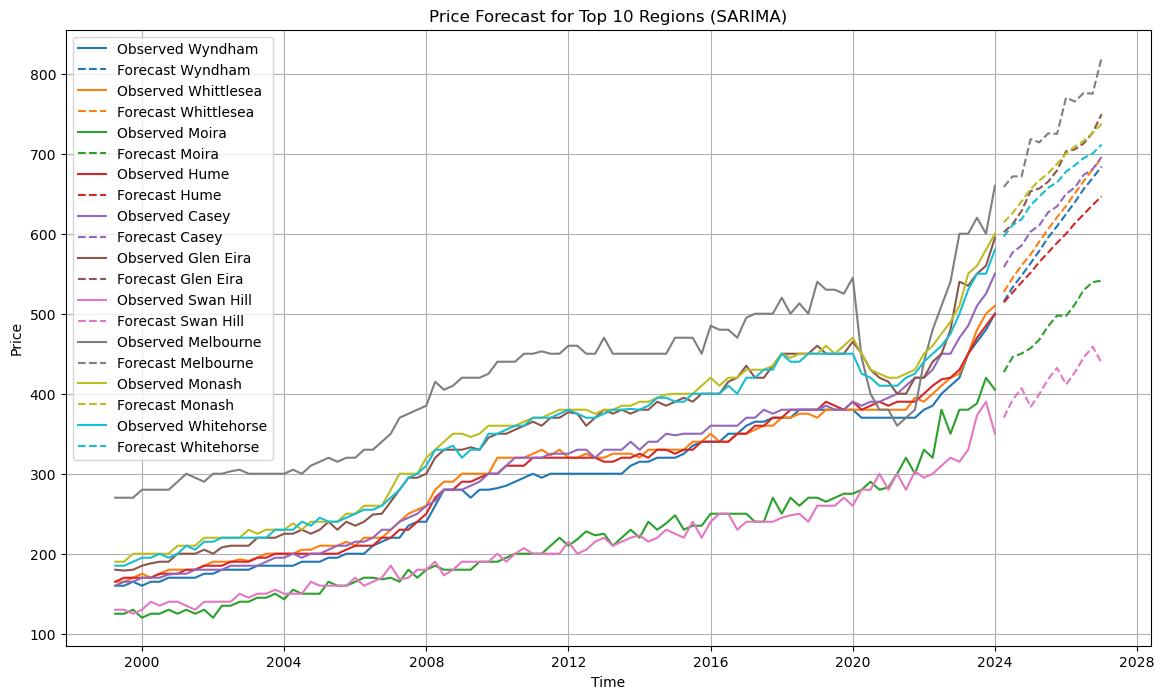

In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
import os
import sys
sys.path.append('..') 
from scripts.save_plot import save_plot

df = pd.read_csv('../data/curated/final_merged_data_sa2.csv')

price_columns = [col for col in df.columns if re.match(r'\b[A-Za-z]{3}\s\d{4}\smedian\b', col)]

df_prices = df[['LGA', 'SA2'] + price_columns]  

df_prices_unique = df_prices.groupby('LGA').first().reset_index()

price_columns_filtered = [col for col in df_prices_unique.columns if 'median' in col]

df_prices_unique.set_index('LGA', inplace=True)

df_prices_unique = df_prices_unique[price_columns_filtered]

df_prices_unique.columns = pd.to_datetime([col.replace(' median', '') for col in df_prices_unique.columns], errors='coerce', format='%b %Y')

df_prices_t = df_prices_unique.T

df_prices_t.index = pd.period_range(start='1999Q2', periods=len(df_prices_t.index), freq='Q')  

test_regions = df_prices_t.columns 

forecast_horizon = 12

predictions = {}

for region in test_regions:
    print(f"Processing {region}...")
    
    ts = df_prices_t[region].dropna()

    p, d, q = 1, 1, 1 
    P, D, Q, m = 1, 1, 1, 4  
    
    try:
        model = sm.tsa.SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, m))
        sarima_fit = model.fit(disp=False)
    
        forecast = sarima_fit.get_forecast(steps=forecast_horizon)
        forecast_values = forecast.predicted_mean
    
        predictions[region] = forecast_values
    except Exception as e:
        print(f"Error processing {region}: {e}")

predictions_df = pd.DataFrame(predictions, index=pd.period_range(start=df_prices_t.index[-1] + 1, periods=forecast_horizon, freq='Q'))

current_prices = df_prices_t.iloc[-1][test_regions]

future_prices = predictions_df.iloc[-1]

price_increase = (future_prices - current_prices) / current_prices * 100

top_regions = price_increase.nlargest(10)  
print("The regions with the highest projected growth over the next three years:")
print(top_regions)

price_increase_df = pd.DataFrame({
    'LGA': price_increase.index,
    'Future Price Increase (%)': price_increase.values
})

# Define the output file path
output_path = '../data/results/price_increase_forecast_SARIMA.csv'
# Ensure the directory exists before saving the file
os.makedirs(os.path.dirname(output_path), exist_ok=True)
# Save the DataFrame to the specified CSV file
price_increase_df.to_csv(output_path, index=False)
print(f"Price increase forecast saved to {output_path}")

plt.figure(figsize=(14, 8))

colors = plt.cm.get_cmap('tab10', len(top_regions))  

for i, region in enumerate(top_regions.index):
    plt.plot(df_prices_t.index.to_timestamp(), df_prices_t[region], label=f"Observed {region}", color=colors(i))
    plt.plot(predictions_df.index.to_timestamp(), predictions_df[region], label=f"Forecast {region}", linestyle='--', color=colors(i))

plt.title("Price Forecast for Top 10 Regions (SARIMA)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

# Save the plot using the save_plot function
save_plot(plt.gcf(), 'price_forecast_top10_SARIMA.png', output_dir='../plots')
plt.show()



Processing Alpine...


00:31:49 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing
00:31:50 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing


Processing Ararat...


00:31:50 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing


Processing Ballarat...


00:31:50 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing


Processing Banyule...


00:31:51 - cmdstanpy - INFO - Chain [1] start processing
00:31:51 - cmdstanpy - INFO - Chain [1] done processing


Processing Bass Coast...


00:31:51 - cmdstanpy - INFO - Chain [1] start processing


Processing Baw Baw...


00:31:51 - cmdstanpy - INFO - Chain [1] done processing
00:31:51 - cmdstanpy - INFO - Chain [1] start processing
00:31:51 - cmdstanpy - INFO - Chain [1] done processing


Processing Benalla...


00:31:52 - cmdstanpy - INFO - Chain [1] start processing
00:31:52 - cmdstanpy - INFO - Chain [1] done processing


Processing Boroondara...


00:31:52 - cmdstanpy - INFO - Chain [1] start processing
00:31:52 - cmdstanpy - INFO - Chain [1] done processing


Processing Brimbank...


00:31:53 - cmdstanpy - INFO - Chain [1] start processing
00:31:53 - cmdstanpy - INFO - Chain [1] done processing


Processing Campaspe...


00:31:54 - cmdstanpy - INFO - Chain [1] start processing


Processing Cardinia...


00:31:54 - cmdstanpy - INFO - Chain [1] done processing
00:31:54 - cmdstanpy - INFO - Chain [1] start processing


Processing Casey...


00:31:54 - cmdstanpy - INFO - Chain [1] done processing
00:31:55 - cmdstanpy - INFO - Chain [1] start processing


Processing Central Goldfields...


00:31:55 - cmdstanpy - INFO - Chain [1] done processing
00:31:55 - cmdstanpy - INFO - Chain [1] start processing
00:31:55 - cmdstanpy - INFO - Chain [1] done processing


Processing Colac-Otway...


00:31:55 - cmdstanpy - INFO - Chain [1] start processing


Processing Corangamite...


00:31:56 - cmdstanpy - INFO - Chain [1] done processing
00:31:56 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing


Processing Darebin...


00:31:56 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing


Processing East Gippsland...


00:31:56 - cmdstanpy - INFO - Chain [1] start processing
00:31:57 - cmdstanpy - INFO - Chain [1] done processing


Processing Frankston...


00:31:57 - cmdstanpy - INFO - Chain [1] start processing
00:31:57 - cmdstanpy - INFO - Chain [1] done processing


Processing Gannawarra...


00:31:57 - cmdstanpy - INFO - Chain [1] start processing
00:31:57 - cmdstanpy - INFO - Chain [1] done processing


Processing Glen Eira...


00:31:57 - cmdstanpy - INFO - Chain [1] start processing
00:31:57 - cmdstanpy - INFO - Chain [1] done processing


Processing Glenelg...


00:31:57 - cmdstanpy - INFO - Chain [1] start processing
00:31:57 - cmdstanpy - INFO - Chain [1] done processing


Processing Golden Plains...
Processing Greater Bendigo...


00:31:58 - cmdstanpy - INFO - Chain [1] start processing
00:31:59 - cmdstanpy - INFO - Chain [1] done processing
00:31:59 - cmdstanpy - INFO - Chain [1] start processing


Processing Greater Dandenong...


00:32:00 - cmdstanpy - INFO - Chain [1] done processing
00:32:00 - cmdstanpy - INFO - Chain [1] start processing
00:32:00 - cmdstanpy - INFO - Chain [1] done processing


Processing Greater Geelong...


00:32:00 - cmdstanpy - INFO - Chain [1] start processing
00:32:00 - cmdstanpy - INFO - Chain [1] done processing


Processing Greater Shepparton...


00:32:01 - cmdstanpy - INFO - Chain [1] start processing
00:32:01 - cmdstanpy - INFO - Chain [1] done processing


Processing Hepburn...


00:32:01 - cmdstanpy - INFO - Chain [1] start processing
00:32:01 - cmdstanpy - INFO - Chain [1] done processing


Processing Hindmarsh...


00:32:01 - cmdstanpy - INFO - Chain [1] start processing
00:32:01 - cmdstanpy - INFO - Chain [1] done processing


Processing Hobsons Bay...


00:32:02 - cmdstanpy - INFO - Chain [1] start processing
00:32:02 - cmdstanpy - INFO - Chain [1] done processing


Processing Horsham...


00:32:02 - cmdstanpy - INFO - Chain [1] start processing
00:32:02 - cmdstanpy - INFO - Chain [1] done processing


Processing Hume...


00:32:03 - cmdstanpy - INFO - Chain [1] start processing


Processing Indigo...


00:32:03 - cmdstanpy - INFO - Chain [1] done processing


Processing Knox...


00:32:05 - cmdstanpy - INFO - Chain [1] start processing
00:32:05 - cmdstanpy - INFO - Chain [1] done processing
00:32:06 - cmdstanpy - INFO - Chain [1] start processing
00:32:06 - cmdstanpy - INFO - Chain [1] done processing


Processing Macedon Ranges...


00:32:06 - cmdstanpy - INFO - Chain [1] start processing


Processing Manningham...


00:32:06 - cmdstanpy - INFO - Chain [1] done processing
00:32:06 - cmdstanpy - INFO - Chain [1] start processing
00:32:07 - cmdstanpy - INFO - Chain [1] done processing


Processing Mansfield...


00:32:07 - cmdstanpy - INFO - Chain [1] start processing
00:32:07 - cmdstanpy - INFO - Chain [1] done processing


Processing Maribyrnong...


00:32:08 - cmdstanpy - INFO - Chain [1] start processing


Processing Maroondah...


00:32:08 - cmdstanpy - INFO - Chain [1] done processing
00:32:09 - cmdstanpy - INFO - Chain [1] start processing


Processing Melbourne...


00:32:09 - cmdstanpy - INFO - Chain [1] done processing
00:32:09 - cmdstanpy - INFO - Chain [1] start processing
00:32:09 - cmdstanpy - INFO - Chain [1] done processing


Processing Melton...


00:32:09 - cmdstanpy - INFO - Chain [1] start processing


Processing Mildura...


00:32:10 - cmdstanpy - INFO - Chain [1] done processing
00:32:10 - cmdstanpy - INFO - Chain [1] start processing


Processing Mitchell...


00:32:10 - cmdstanpy - INFO - Chain [1] done processing


Processing Moira...


00:32:11 - cmdstanpy - INFO - Chain [1] start processing
00:32:12 - cmdstanpy - INFO - Chain [1] done processing
00:32:12 - cmdstanpy - INFO - Chain [1] start processing


Processing Monash...


00:32:12 - cmdstanpy - INFO - Chain [1] done processing
00:32:12 - cmdstanpy - INFO - Chain [1] start processing
00:32:12 - cmdstanpy - INFO - Chain [1] done processing


Processing Moonee Valley...


00:32:13 - cmdstanpy - INFO - Chain [1] start processing
00:32:13 - cmdstanpy - INFO - Chain [1] done processing


Processing Moorabool...


00:32:13 - cmdstanpy - INFO - Chain [1] start processing
00:32:13 - cmdstanpy - INFO - Chain [1] done processing


Processing Mount Alexander...


00:32:13 - cmdstanpy - INFO - Chain [1] start processing
00:32:13 - cmdstanpy - INFO - Chain [1] done processing


Processing Moyne...
Processing Murrindindi...


00:32:14 - cmdstanpy - INFO - Chain [1] start processing
00:32:14 - cmdstanpy - INFO - Chain [1] done processing
00:32:14 - cmdstanpy - INFO - Chain [1] start processing
00:32:14 - cmdstanpy - INFO - Chain [1] done processing


Processing Nillumbik...


00:32:14 - cmdstanpy - INFO - Chain [1] start processing
00:32:14 - cmdstanpy - INFO - Chain [1] done processing


Processing Northern Grampians...


00:32:15 - cmdstanpy - INFO - Chain [1] start processing
00:32:15 - cmdstanpy - INFO - Chain [1] done processing


Processing Port Phillip...


00:32:15 - cmdstanpy - INFO - Chain [1] start processing
00:32:15 - cmdstanpy - INFO - Chain [1] done processing


Processing South Gippsland...


00:32:15 - cmdstanpy - INFO - Chain [1] start processing
00:32:15 - cmdstanpy - INFO - Chain [1] done processing


Processing Southern Grampians...


00:32:16 - cmdstanpy - INFO - Chain [1] start processing
00:32:16 - cmdstanpy - INFO - Chain [1] done processing


Processing Stonnington...


00:32:16 - cmdstanpy - INFO - Chain [1] start processing
00:32:16 - cmdstanpy - INFO - Chain [1] done processing


Processing Surf Coast...


00:32:16 - cmdstanpy - INFO - Chain [1] start processing
00:32:16 - cmdstanpy - INFO - Chain [1] done processing


Processing Swan Hill...


00:32:17 - cmdstanpy - INFO - Chain [1] start processing
00:32:17 - cmdstanpy - INFO - Chain [1] done processing


Processing Towong...
Processing Wangaratta...


00:32:17 - cmdstanpy - INFO - Chain [1] start processing
00:32:17 - cmdstanpy - INFO - Chain [1] done processing
00:32:17 - cmdstanpy - INFO - Chain [1] start processing
00:32:18 - cmdstanpy - INFO - Chain [1] done processing


Processing Wellington...


00:32:18 - cmdstanpy - INFO - Chain [1] start processing
00:32:18 - cmdstanpy - INFO - Chain [1] done processing


Processing Whitehorse...


00:32:18 - cmdstanpy - INFO - Chain [1] start processing
00:32:18 - cmdstanpy - INFO - Chain [1] done processing


Processing Whittlesea...


00:32:18 - cmdstanpy - INFO - Chain [1] start processing


Processing Wodonga...


00:32:18 - cmdstanpy - INFO - Chain [1] done processing
00:32:19 - cmdstanpy - INFO - Chain [1] start processing


Processing Wyndham...


00:32:19 - cmdstanpy - INFO - Chain [1] done processing
00:32:19 - cmdstanpy - INFO - Chain [1] start processing
00:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing Yarra...


00:32:19 - cmdstanpy - INFO - Chain [1] start processing
00:32:20 - cmdstanpy - INFO - Chain [1] done processing


Processing Yarra Ranges...


/var/folders/8_/gylgnm051zv9rk4m5lzq6c880000gn/T/ipykernel_39248/1274918839.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(top_regions))


The regions with the highest projected growth over the next three years:
Corangamite        23.764265
Alpine             21.938616
Benalla            21.690267
Glenelg            21.423556
South Gippsland    21.164959
Wellington         21.066161
Moyne              20.150627
Greater Bendigo    18.566806
Colac-Otway        18.141860
East Gippsland     16.642525
dtype: float64
Plot saved at ../plots/price_forecast_top10_Prophet.png


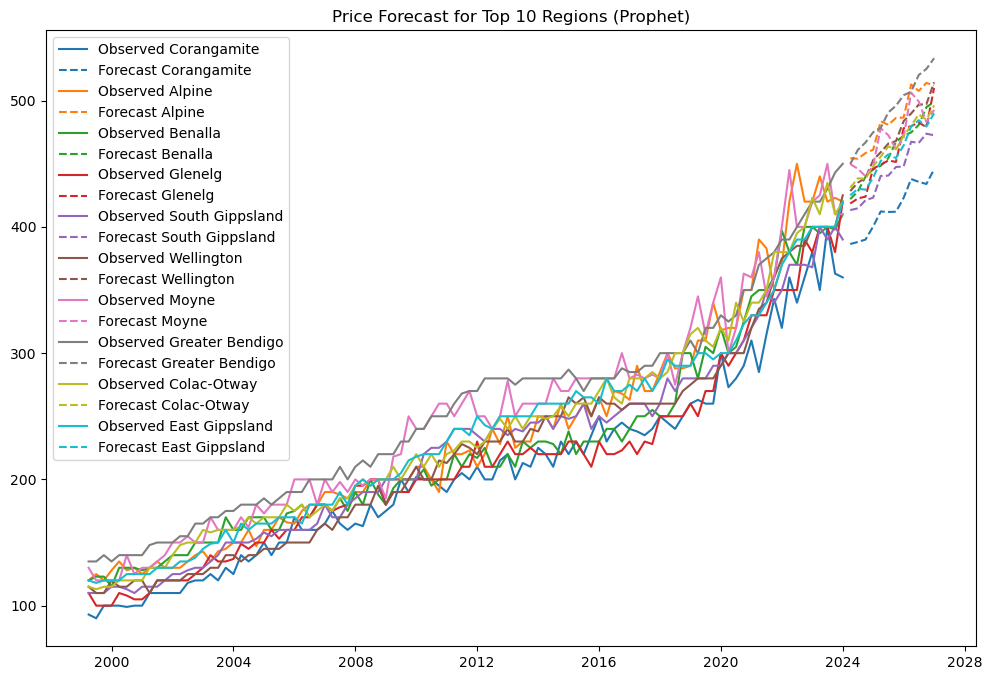

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

df = pd.read_csv('../data/curated/final_merged_data_sa2.csv')

import re
price_columns = [col for col in df.columns if re.match(r'\b[A-Za-z]{3}\s\d{4}\smedian\b', col)]

df_prices = df[['LGA'] + price_columns]

df_prices_unique = df_prices.groupby('LGA').first()

df_prices_unique.columns = pd.to_datetime([col.replace(' median', '') for col in df_prices_unique.columns], errors='coerce', format='%b %Y')

df_prices_t = df_prices_unique.T

df_prices_t.index = pd.period_range(start='1999Q2', periods=len(df_prices_t.index), freq='Q') 

regions = df_prices_t.columns  

forecast_horizon = 12

predictions = {}

for region in regions:
    print(f"Processing {region}...")
    
    ts = df_prices_t[region].dropna()
    
    prophet_df = pd.DataFrame({
        'ds': ts.index.to_timestamp(),  
        'y': ts.values
    })
    
    model = Prophet()
    model.fit(prophet_df)
    
    future = model.make_future_dataframe(periods=forecast_horizon, freq='Q')
    
    forecast = model.predict(future)
    
    predictions[region] = forecast[['ds', 'yhat']].set_index('ds')['yhat'][-forecast_horizon:]  
    
predictions_df = pd.DataFrame(predictions)

current_prices = df_prices_t.iloc[-1][regions]

future_prices = predictions_df.iloc[-1]

price_increase = (future_prices - current_prices) / current_prices * 100

top_regions = price_increase.nlargest(10)  
print("The regions with the highest projected growth over the next three years:")
print(top_regions)

plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', len(top_regions)) 

for i, region in enumerate(top_regions.index):
    plt.plot(df_prices_t.index.to_timestamp(), df_prices_t[region], label=f"Observed {region}", color=colors(i))
    
    plt.plot(predictions_df.index, predictions_df[region], label=f"Forecast {region}", linestyle='--', color=colors(i))

plt.title("Price Forecast for Top 10 Regions (Prophet)")
plt.legend()
# Save the plot using the save_plot function
save_plot(plt.gcf(), 'price_forecast_top10_Prophet.png', output_dir='../plots')

plt.show()



price_increase_df = pd.DataFrame({
    'LGA': price_increase.index,
    'Future Price Increase (%)': price_increase.values
})

price_increase_df.to_csv('../data/results/price_increase_forecast_prophet.csv', index=False)

